In [6]:
import numpy as np
import scipy.io as sio 
import scipy.signal as sig
from matplotlib import pyplot as plt
%matplotlib inline
import random 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, Normalizer
import tensorflow 
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Reshape, Conv1D
from tensorflow.keras.regularizers import l2
import math
import seaborn as sns

In [7]:
dat = sio.loadmat('/Users/soumilhooda/Documents/BCI/Data/BCICIV_4_mat/sub1_comp.mat',struct_as_record=True)
tdat = sio.loadmat('/Users/soumilhooda/Documents/BCI/Data/sub1_testlabels.mat',struct_as_record=True)

train_data = dat['train_data']
test_data = dat['test_data']
train_dg = dat['train_dg']
test_dg = tdat['test_dg']

train_samples,channels = train_data.shape
test_samples = test_data.shape[0]  
channel_train_data = np.transpose(train_data,(1,0))
channel_test_data = np.transpose(test_data,(1,0))
finger_train_data = np.transpose(train_dg,(1,0))
finger_test_data = np.transpose(test_dg,(1,0))

sampling_frequency = 1000

In [8]:
# FIR filter 
def bandPass(signal,fl,fh):
    taps = 505
    band = np.array([fl,fh])
    h = sig.firwin(taps,band,fs=sampling_frequency,pass_zero='bandpass')
    output = np.convolve(signal,h,mode='same')
    return output

# Amplitude modulation : 
def AM(signal):
    cur = 0
    output = []
    for i in range(len(signal)):
        if(i and i % 40 == 0):
            output.append(cur)
            cur = 0
        cur += signal[i]**2
    output.append(cur)
         
    return output

def assign_states(finger_data):
    # State assignment : (0 : rest, 1-5 finger flexed)
    dsamples = len(finger_data[0])
    states = [None]*dsamples
    threshold_1,threshold_2  = 2.0,1.0
    for i in range(dsamples):
        flex,rest = 0,0
        for j in range(5):
            if finger_data[j][i] >= threshold_1:
                states[i] = j + 1
                flex += 1
            elif finger_data[j][i] < threshold_2:
                rest += 1
        if states[i] == None:
            if rest:
                states[i] = 0

    return states

def restrict_zeroes(states):
    # Randomly restrict zeroes in a continuous region and return indices
    ends = []
    z_buckets = []
    cur = 0
    for i in range(len(states)):
        if(states[i] == 0):
            cur += 1
        else:
            if(cur == 0):
                continue
            z_buckets.append(cur)
            ends.append(i-1)
            cur = 0

    if(cur):
        z_buckets.append(cur)
        ends.append(len(states)-1)

    keeps = []
    for i in range(len(ends)):
        start = ends[i] - z_buckets[i] + 1
        rl = random.sample(range(start,ends[i]),min(3,z_buckets[i]-1))
        rl = sorted(rl)
        for e in rl:
            keeps.append(e)

    for i in range(len(states)):
        if(states[i]):
            keeps.append(i)

    keeps = sorted(keeps)
    return keeps

def equalize(states):
    freq = [0]*6
    for s in states:
        freq[s] += 1
    mini = min(freq)
    target = [min(freq[i],mini + 50) for i in range(6)]
    scale = [freq[i] / target[i] for i in range(6)]

    keeps = []
    cur = 1
    for i in range(1,len(states)):
        if(states[i] == states[i-1]):
            cur += 1
        else:
            if(states[i-1] == 0):
                if(cur > 20):
                    cur = min(cur,3)
                else:
                    cur = min(cur,1)
            else:
                cur = math.ceil(cur/scale[states[i-1]])
            for j in range(cur):
                keeps.append(i-1-j)
            cur = 1 

    keeps = sorted(keeps)
    return keeps    

def resize_ch(signal,states,keeps):
    new_ch = []
    for i in range(len(signal)):
        curch = []
        idx = 0
        for j in range(len(states)):
            if(idx < len(keeps) and j == keeps[idx]):
                curch.append(signal[i][j])
                idx += 1
        new_ch.append(curch)

    return new_ch

def resize_states(states,keeps):
    new_states = []
    idx = 0
    for i in range(len(states)):
        if(idx < len(keeps) and i == keeps[idx]):
            new_states.append(states[i])
            idx += 1

    return new_states 

In [9]:
# Finger data downsampling : 
finger_train_data_ds = [None]*5
for i in range(5):
    finger_train_data_ds[i] = [finger_train_data[i][j] for j in range(0,train_samples,40)]

finger_test_data_ds = [None]*5
for i in range(5):
    finger_test_data_ds[i] = [finger_test_data[i][j] for j in range(0,test_samples,40)]

In [10]:
finger_train_states = assign_states(finger_train_data_ds)
finger_test_states = assign_states(finger_test_data_ds)

train_keeps = restrict_zeroes(finger_train_states)
test_keeps = equalize(finger_test_states)

In [11]:
# Seperate channel_data into frequency bands : 
train_sub_band = [bandPass(x,1,60) for x in channel_train_data]
train_gamma_band = [bandPass(x,60,100) for x in channel_train_data]
train_fast_gamma_band = [bandPass(x,100,200) for x in channel_train_data]
test_sub_band = [bandPass(x,1,60) for x in channel_test_data]
test_gamma_band = [bandPass(x,60,100) for x in channel_test_data]
test_fast_gamma_band = [bandPass(x,100,200) for x in channel_test_data]

In [14]:
# Perform amplitude modulation on each band :
train_sub_band = [AM(x) for x in train_sub_band]
train_gamma_band = [AM(x) for x in train_gamma_band]
train_fast_gamma_band = [AM(x) for x in train_fast_gamma_band]
train_full_band = [AM(x) for x in channel_train_data]
test_sub_band = [AM(x) for x in test_sub_band]
test_gamma_band = [AM(x) for x in test_gamma_band]
test_fast_gamma_band = [AM(x) for x in test_fast_gamma_band]
test_full_band = [AM(x) for x in channel_test_data]

In [15]:
train_sub_rz = resize_ch(train_sub_band,finger_train_states,train_keeps)
train_gamma_rz = resize_ch(train_gamma_band,finger_train_states,train_keeps)
train_fast_gamma_rz = resize_ch(train_fast_gamma_band,finger_train_states,train_keeps)
train_full_rz = resize_ch(train_full_band,finger_train_states,train_keeps)
finger_train_states_rz = resize_states(finger_train_states,train_keeps) 

test_sub_rz = resize_ch(test_sub_band,finger_test_states,test_keeps)
test_gamma_rz = resize_ch(test_gamma_band,finger_test_states,test_keeps)
test_fast_gamma_rz = resize_ch(test_fast_gamma_band,finger_test_states,test_keeps)
test_full_rz = resize_ch(test_full_band,finger_test_states,test_keeps)
finger_test_states_rz = resize_states(finger_test_states,test_keeps)

In [16]:
# Final Numpy arrays with 4 ECoG arrays and 1 Finger array each for train and test : 

# Train : 
tr_s1_sub = np.array(train_sub_rz)
tr_s1_gamma = np.array(train_gamma_rz)
tr_s1_fastgamma = np.array(train_fast_gamma_rz)
tr_s1_all = np.array(train_full_rz)
tr_s1_finger = np.array(finger_train_states_rz)

# Test :
te_s1_sub = np.array(test_sub_rz)
te_s1_gamma = np.array(test_gamma_rz)
te_s1_fastgamma = np.array(test_fast_gamma_rz)
te_s1_all = np.array(test_full_rz)
te_s1_finger = np.array(finger_test_states_rz)

In [17]:
# Finger One-Hot Encoding

tr_s1_finger = tr_s1_finger.reshape(len(tr_s1_finger), 1)
tr_s1_finger = OneHotEncoder(sparse=False).fit_transform(tr_s1_finger)

te_s1_finger = te_s1_finger.reshape(len(te_s1_finger), 1)
te_s1_finger = OneHotEncoder(sparse=False).fit_transform(te_s1_finger)

In [18]:
tr_s1_sub = tr_s1_sub.T
tr_s1_gamma = tr_s1_gamma.T
tr_s1_fastgamma = tr_s1_fastgamma.T
tr_s1_all = tr_s1_all.T

te_s1_sub = te_s1_sub.T
te_s1_gamma = te_s1_gamma.T
te_s1_fastgamma = te_s1_fastgamma.T
te_s1_all = te_s1_all.T

In [19]:
print(tr_s1_gamma.shape)
print(te_s1_gamma.shape)

(4580, 62)
(2104, 62)


In [20]:
# ECoG Normalization

tr_s1_sub = Normalizer().fit(tr_s1_sub).transform(tr_s1_sub)
tr_s1_gamma = Normalizer().fit(tr_s1_gamma).transform(tr_s1_gamma)
tr_s1_fastgamma = Normalizer().fit(tr_s1_fastgamma).transform(tr_s1_fastgamma)
tr_s1_all = Normalizer().fit(tr_s1_all).transform(tr_s1_all)

te_s1_sub = Normalizer().fit(te_s1_sub).transform(te_s1_sub)
te_s1_gamma = Normalizer().fit(te_s1_gamma).transform(te_s1_gamma)
te_s1_fastgamma = Normalizer().fit(te_s1_fastgamma).transform(te_s1_fastgamma)
te_s1_all = Normalizer().fit(te_s1_all).transform(te_s1_all)

In [21]:
# Reshape to 3D Structure for Conv and BiLSTM

tr_s1_sub = tr_s1_sub.reshape(len(tr_s1_sub),1,len(tr_s1_sub[0]))
tr_s1_gamma = tr_s1_gamma.reshape(len(tr_s1_gamma),1,len(tr_s1_gamma[0]))
tr_s1_fastgamma = tr_s1_fastgamma.reshape(len(tr_s1_fastgamma),1,len(tr_s1_fastgamma[0]))
tr_s1_all = tr_s1_all.reshape(len(tr_s1_all),1,len(tr_s1_all[0]))

te_s1_sub = te_s1_sub.reshape(len(te_s1_sub),1,len(te_s1_sub[0]))
te_s1_gamma = te_s1_gamma.reshape(len(te_s1_gamma),1,len(te_s1_gamma[0]))
te_s1_fastgamma = te_s1_fastgamma.reshape(len(te_s1_fastgamma),1,len(te_s1_fastgamma[0]))
te_s1_all = te_s1_all.reshape(len(te_s1_all),1,len(te_s1_all[0]))

In [22]:
print(tr_s1_sub.shape)
print(tr_s1_gamma.shape)
print(tr_s1_fastgamma.shape)
print(tr_s1_all.shape)
print(te_s1_sub.shape)
print(te_s1_gamma.shape)
print(te_s1_fastgamma.shape)
print(te_s1_all.shape)

(4580, 1, 62)
(4580, 1, 62)
(4580, 1, 62)
(4580, 1, 62)
(2104, 1, 62)
(2104, 1, 62)
(2104, 1, 62)
(2104, 1, 62)


In [23]:
np.random.seed(0)

In [24]:
tr_s1_finger_nonhotencoded = np.argmax(tr_s1_finger,axis=1)
te_s1_finger_nonhotencoded = np.argmax(te_s1_finger,axis=1)

Sub-Band data for Subject 1.

In [33]:
# MODEL

model_s1_sub = keras.Sequential()
model_s1_sub.add(Conv1D(62, 1, activation='relu', input_shape=(1,62)))
model_s1_sub.add(Conv1D(48, 1, activation='relu', ))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_s1_sub.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_s1_sub.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_s1_sub.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_s1_sub.summary()

history = model_s1_sub.fit(tr_s1_sub, tr_s1_finger, batch_size = 10, epochs=500, validation_split=0.1)

predictions_tr_sub = model_s1_sub.predict(tr_s1_sub)
predictions_te_sub = model_s1_sub.predict(te_s1_sub)
predictions_tr_sub = np.argmax(predictions_tr_sub, axis = 1)
predictions_te_sub = np.argmax(predictions_te_sub, axis = 1)
np.savetxt('predictions_tr_sub.txt',predictions_tr_sub)
np.savetxt('predictions_te_sub.txt',predictions_te_sub)


print("Train accuracy : ",accuracy_score(tr_s1_finger_nonhotencoded, predictions_tr_sub))
print("Test accuracy : ",accuracy_score(te_s1_finger_nonhotencoded, predictions_te_sub))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 1, 62)             3906      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1, 48)             3024      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 24)                5856      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 150       
Total params: 12,936
Trainable params: 12,936
Non-trainable params: 0
_________________________________________________________________
Train on 4122 samples, validate on 458 samples
Epoch 1/500
4122/4122 [==============================] - 9s 2ms/sample - loss: 1.6815 - mae: 0.2634 - mse: 0.1317 - val_loss: 1.7310 - val_mae: 0.2679 - val_mse: 0.1337
Epoch 2/500
4122/4122 [=========

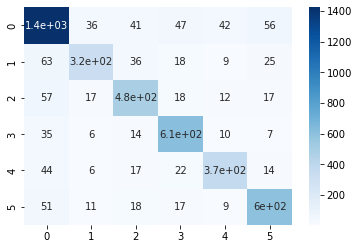

In [34]:
# Train Confusion Matrix
conf_tr_sub = confusion_matrix(tr_s1_finger_nonhotencoded, predictions_tr_sub)
sns.heatmap(conf_tr_sub, annot=True, cmap='Blues')
plt.show()

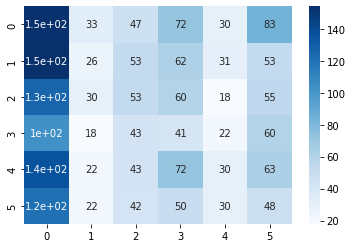

In [35]:
# Test Confusion Matrix
conf_te_sub = confusion_matrix(te_s1_finger_nonhotencoded, predictions_te_sub)
sns.heatmap(conf_te_sub, annot=True, cmap='Blues')
plt.show()

Gamma-Band for Subject 1.

In [ ]:
# MODEL

model_s1_gamma = keras.Sequential()
model_s1_gamma.add(Conv1D(62, 1, activation='relu', input_shape=(1,62)))
model_s1_gamma.add(Conv1D(48, 1, activation='relu', ))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_s1_gamma.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_s1_gamma.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_s1_gamma.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_s1_gamma.summary()

history = model_s1_gamma.fit(tr_s1_gamma, tr_s1_finger, batch_size = 10, epochs=500, validation_split=0.1)

predictions_tr_gamma = model_s1_gamma.predict(tr_s1_gamma)
predictions_te_gamma = model_s1_gamma.predict(te_s1_gamma)
predictions_tr_gamma = np.argmax(predictions_tr_gamma, axis = 1)
predictions_te_gamma = np.argmax(predictions_te_gamma, axis = 1)
np.savetxt('predictions_tr_gamma.txt',predictions_tr_gamma)
np.savetxt('predictions_te_gamma.txt',predictions_te_gamma)


print("Train accuracy : ",accuracy_score(tr_s1_finger_nonhotencoded, predictions_tr_gamma))
print("Test accuracy : ",accuracy_score(te_s1_finger_nonhotencoded, predictions_te_gamma))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1, 62)             3906      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 48)             3024      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24)                5856      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 150       
Total params: 12,936
Trainable params: 12,936
Non-trainable params: 0
_________________________________________________________________
Train on 4580 samples
Epoch 1/500
4580/4580 [==============================] - 7s 2ms/sample - loss: 1.6338 - mae: 0.2582 - mse: 0.1293
Epoch 2/500
4580/4580 [==============================] - 3s 750us/sample - loss: 1.5476 - mae: 0.2482 - mse: 0.1

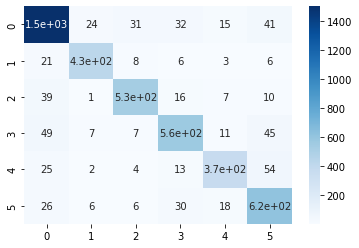

In [ ]:
# Train Confusion Matrix
conf_tr_gamma = confusion_matrix(tr_s1_finger_nonhotencoded, predictions_tr_gamma)
sns.heatmap(conf_tr_gamma, annot=True, cmap='Blues')
plt.show()

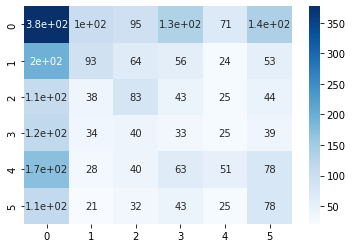

In [ ]:
# Test Confusion Matrix
conf_te_gamma = confusion_matrix(te_s1_finger_nonhotencoded, predictions_te_gamma)
sns.heatmap(conf_te_gamma, annot=True, cmap='Blues')
plt.show()

Fast-Gamma-Band for Subject 1.

In [ ]:
# MODEL

model_s1_fastgamma = keras.Sequential()
model_s1_fastgamma.add(Conv1D(62, 1, activation='relu', input_shape=(1,62)))
model_s1_fastgamma.add(Conv1D(48, 1, activation='relu', ))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_s1_fastgamma.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_s1_fastgamma.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_s1_fastgamma.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_s1_fastgamma.summary()

history = model_s1_fastgamma.fit(tr_s1_fastgamma, tr_s1_finger, batch_size = 10, epochs=500, validation_split=0.1)

predictions_tr_fastgamma = model_s1_fastgamma.predict(tr_s1_fastgamma)
predictions_te_fastgamma = model_s1_fastgamma.predict(te_s1_fastgamma)
predictions_tr_fastgamma = np.argmax(predictions_tr_fastgamma, axis = 1)
predictions_te_fastgamma = np.argmax(predictions_te_fastgamma, axis = 1)
np.savetxt('predictions_tr_fastgamma.txt',predictions_tr_fastgamma)
np.savetxt('predictions_te_fastgamma.txt',predictions_te_fastgamma)


print("Train accuracy : ",accuracy_score(tr_s1_finger_nonhotencoded, predictions_tr_fastgamma))
print("Test accuracy : ",accuracy_score(te_s1_finger_nonhotencoded, predictions_te_fastgamma))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 62)             3906      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 48)             3024      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 24)                5856      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 12,936
Trainable params: 12,936
Non-trainable params: 0
_________________________________________________________________
Train on 4580 samples
Epoch 1/500
4580/4580 [==============================] - 8s 2ms/sample - loss: 1.6569 - mae: 0.2603 - mse: 0.1304
Epoch 2/500
4580/4580 [==============================] - 3s 664us/sample - loss: 1.5496 - mae: 0.2485 - mse: 0.1

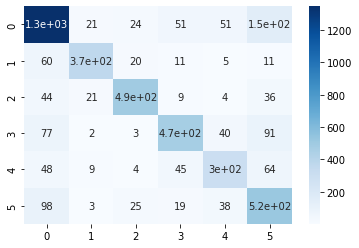

In [ ]:
# Train Confusion Matrix
conf_tr_fastgamma = confusion_matrix(tr_s1_finger_nonhotencoded, predictions_tr_fastgamma)
sns.heatmap(conf_tr_fastgamma, annot=True, cmap='Blues')
plt.show()

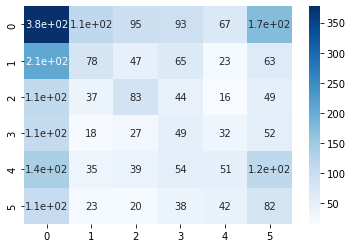

In [ ]:
# Test Confusion Matrix
conf_te_fastgamma = confusion_matrix(te_s1_finger_nonhotencoded, predictions_te_fastgamma)
sns.heatmap(conf_te_fastgamma, annot=True, cmap='Blues')
plt.show()

All-Bands for Subject 1.

In [36]:
# MODEL

model_s1_all = keras.Sequential()
model_s1_all.add(Conv1D(62, 1, activation='relu', input_shape=(1,62)))
model_s1_all.add(Conv1D(48, 1, activation='relu', ))
forward_layer = LSTM(12, activation='relu')
backward_layer = LSTM(12, activation='relu', go_backwards=True)
model_s1_all.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model_s1_all.add(Dense(6, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.005)
model_s1_all.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['mae','mse'])
model_s1_all.summary()

history = model_s1_all.fit(tr_s1_all, tr_s1_finger, batch_size = 10, epochs=500, validation_split=0.1)

predictions_tr_all = model_s1_all.predict(tr_s1_all)
predictions_te_all = model_s1_all.predict(te_s1_all)
predictions_tr_all = np.argmax(predictions_tr_all, axis = 1)
predictions_te_all = np.argmax(predictions_te_all, axis = 1)
np.savetxt('predictions_tr_all.txt',predictions_tr_all)
np.savetxt('predictions_te_all.txt',predictions_te_all)


print("Train accuracy : ",accuracy_score(tr_s1_finger_nonhotencoded, predictions_tr_all))
print("Test accuracy : ",accuracy_score(te_s1_finger_nonhotencoded, predictions_te_all))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1, 62)             3906      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 48)             3024      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 24)                5856      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 150       
Total params: 12,936
Trainable params: 12,936
Non-trainable params: 0
_________________________________________________________________
Train on 4122 samples, validate on 458 samples
Epoch 1/500
4122/4122 [==============================] - 7s 2ms/sample - loss: 1.6744 - mae: 0.2627 - mse: 0.1314 - val_loss: 1.7304 - val_mae: 0.2652 - val_mse: 0.1332
Epoch 2/500
4122/4122 [=========

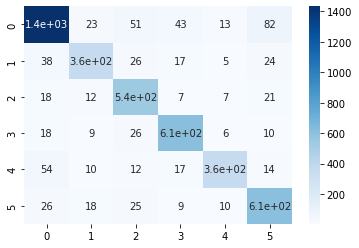

In [37]:
# Train Confusion Matrix
conf_tr_all = confusion_matrix(tr_s1_finger_nonhotencoded, predictions_tr_all)
sns.heatmap(conf_tr_all, annot=True, cmap='Blues')
plt.show()

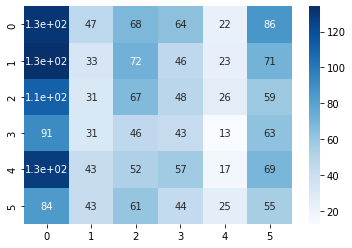

In [38]:
# Test Confusion Matrix
conf_te_all = confusion_matrix(te_s1_finger_nonhotencoded, predictions_te_all)
sns.heatmap(conf_te_all, annot=True, cmap='Blues')
plt.show()

SUMMARY 

In [ ]:
print("Train accuracy for Sub Band: ",accuracy_score(tr_s1_finger_nonhotencoded, predictions_tr_sub))
print("Test accuracy for Sub Band: ",accuracy_score(te_s1_finger_nonhotencoded, predictions_te_sub))
print("Train accuracy for Gamma Band: ",accuracy_score(tr_s1_finger_nonhotencoded, predictions_tr_gamma))
print("Test accuracy for Gamma Band: ",accuracy_score(te_s1_finger_nonhotencoded, predictions_te_gamma))
print("Train accuracy for Fast Gamma Band: ",accuracy_score(tr_s1_finger_nonhotencoded, predictions_tr_fastgamma))
print("Test accuracy for Fast Gamma Band: ",accuracy_score(te_s1_finger_nonhotencoded, predictions_te_fastgamma))
print("Train accuracy for All Band: ",accuracy_score(tr_s1_finger_nonhotencoded, predictions_tr_all))
print("Test accuracy for All Band: ",accuracy_score(te_s1_finger_nonhotencoded, predictions_te_all))

Train accuracy for Sub Band:  0.9482532751091703
Test accuracy for Sub Band:  0.21238300935925125
Train accuracy for Gamma Band:  0.8770742358078603
Test accuracy for Gamma Band:  0.2573794096472282
Train accuracy for Fast Gamma Band:  0.762882096069869
Test accuracy for Fast Gamma Band:  0.2591792656587473
Train accuracy for All Band:  0.9504366812227074
Test accuracy for All Band:  0.21922246220302377
